# Epochs instructional demo 1: from ndi_file_navigator to ndi_daqsystem to ndi_probe

This demo introduces the concepts of using **ndi_daqsystem** objects to access data acquired in an experiment. 

**Scenario**: An experimentor records spontaneously generated responses with a single intracellular sharp electrode inserted in visual cortex. The analyst wants to examine the spiking responses of the neuron and the voltage responses of the neuron with the spiking artificially removed.

**Physical situation**: There is a single physical hardware data acquisition system, in this case a system made by _Cambridge Electronic Deisgn_ (CED) called the _micro1401_ that is controlled by prioprietary software called _Spike2_. A wire connects the electrode to an amplifier, and a wire from the amplifier connects to an input (let's say input 0) on the micro1401.

In **NDI**, a **probe** is anything that measures or stimulates, so our intracellular sharp electrode is an exampe of a probe.

The recordings occur in **epochs**, which are instances when the recording system is turned on to record a bout of activity, and then turned off. Each time the recording is turned on, a file (_.smr_ format) is written to disk. The software that manages the recording of the micro1401 is written by CED and is called Spike2.

Let's say there are 3 recording epochs, which in this example we call `t00001`, `t00002`, and `t00003`. Therefore, we have 3 .smr files (let's say at path `t00001/spike2data.smr`, `t00002/spike2data.smr`, and `t00003/spike2data.smr`). 

First, let's examine the directory, which we will call `dirname`.


In [7]:
ndi_globals;
dirname = [ndiexampleexperpath filesep 'intracell_example']


dirname =

    '/Users/vanhoosr/Documents/MATLAB/tools/NDI-matlab/ndi_common/example_experiments/intracell_example'



In [9]:
ls([dirname filesep '*']) % list all files in subdirectories

/Users/vanhoosr/Documents/MATLAB/tools/NDI-matlab/ndi_common/example_experiments/intracell_example/t00001:
epoch_t00001.epochmetadata	spike2data.smr

/Users/vanhoosr/Documents/MATLAB/tools/NDI-matlab/ndi_common/example_experiments/intracell_example/t00002:
epoch_t00002.epochmetadata	spike2data.smr

/Users/vanhoosr/Documents/MATLAB/tools/NDI-matlab/ndi_common/example_experiments/intracell_example/t00003:
epoch_t00003.epochmetadata	spike2data.smr



Each subdirectory contains a file `spike2data.smr` and another file called `epoch_tN.epochmetadata`.

Let's think about the information we would need to understand the physical situation of our recording. Our electrode amplifier was plugged into a certain channel on the _micro1401_. In the case of the _micro1401_ acquisition system, this channel is assigned a number in the _Spike2_ software (it need not correspond to a port number on the _micro1401_ ). During this acquisition, we happened to use channel 21 as the input channel. So we need to store this metadata (that we have an intracellular sharp electrode probe being sampled on channel 21 of a _micro1401_ device that was acquired with _Spike2_ software). 

There are several ways to provide this data. Some acquisition systems store this metadata in their own native files, and it could be read from those files. Some labs (Van Hooser lab is one) have a system for specifying this metadata in their own "helper" files, and NDI classes have been made to convert this metadata into NDI objects. But, for simplicity, we'll imagine the case where the user writes the values in a text file. Let's look at the contents of the first epoch's text file.

In [10]:
textfile2char([dirname filesep 't00001' filesep 'epoch_t00001.epochmetadata'])


ans =

    'name	reference	type	devicestring
     intra	1	sharp-Vm	mySpike2:ai21
     '



Here, we have the **name** of the probe ( _intra_ ), a **reference** number for the probe (1), a declared **type** of the probe ( _sharp-Vm_ ), and the **devicestring**, which has the daqsystem and channel number where the probe was recorded in this epoch (_mySpike2_ is a daqsystem we haven't defined yet, and 'ai21' means 'analog input number 21', where channels are numbered from 1). The class **ndi_daqsystemstring** creates and writes these devicestrings (see `help ndi_daqsystemstring`). All of these fields together comprise the necessary parameters for the class **ndi_epochprobemap_daqsystem** (see `help ndi_epochprobemap_daqsystem`).

## ndi_filenavigator: managing files for epochs, and their organization on disk

Each lab and even each investigator has their own way of organizing their files into epochs on disk. So we need a flexible tool to retrieve the files that correspond to a particular epoch of recording. The **ndi_filenavigator** provides a flexible means of specifying search parameters for these files; further, if the organization is very specialized, then the class can be overridden. From `help ndi_filenavigator`:

`OBJ = ndi_filenavigator(EXPERIMENT, [ FILEPARAMETERS, EPOCHPROBEMAP_CLASS, EPOCHPROBEMAP_FILEPARAMETERS])`

To create an ndi_filenavigator object, we need to open an **ndi_experiment** object that has a data path -- that is, the root directory of the raw data to be searched.


In [25]:
E = ndi_experiment_dir('exp1',dirname)


E = 

  ndi_experiment_dir with properties:

                path: '/Users/vanhoosr/Documents/MATLAB/tools/NDI-matlab/ndi_common/example_experiments/intracell_example'
           reference: 'exp1'
    unique_reference: '412683f900a604d6_3fe43c49753b9024'
            database: [1x1 ndi_matlabdumbjsondb]
           daqsystem: [1x1 ndi_dbleaf_branch]
           syncgraph: [1x1 ndi_syncgraph]
               cache: [1x1 ndi_cache]



The fileparameters input to the **ndi_filenavigator** creator is a set of regular expression matches that must be satisifed to indicate the presence of a set of files that comprise an epoch. (See `help ndi_filenavigator/setparameters`). In this case, we want to tell the file navigator to look for _.smr_ files that are paired with a _.epochmetadata_ file. So, we write:

In [26]:
fileparameters = {'.*\.smr\>','.*\.epochmetadata\>'}; % the regular expressions must both be matched
epochprobemap_class = 'ndi_epochprobemap_daqsystem';
epochprobemap_fileparameters = '.*\.epochmetadata\>'; % this must match a file that is part of the epoch
fn = ndi_filenavigator(E,fileparameters,epochprobemap_class,epochprobemap_fileparameters);

Now we can examine the epochs of `fn`:

In [27]:
numepochs = fn.numepochs(), % print number of epochs
ef1 = fn.getepochfiles(1), % get the files that comprise the first epoch



numepochs =

     3


ef1 =

  2x1 cell array

    {'/Users/vanhoosr/Documents/MATLAB/tools/NDI-matlab/ndi_common/example_experiments/intracell_example/t00001/spike2data.smr'            }
    {'/Users/vanhoosr/Documents/MATLAB/tools/NDI-matlab/ndi_common/example_experiments/intracell_example/t00001/epoch_t00001.epochmetadata'}



## ndi_epochset: a class for managing sets of epochs

Many NDI objects have epochs (ndi_filenavigator, ndi_daqsystem, ndi_probe, ndi_thing), and these epochs are inter-related. The epochs of a probe are directly related to those of the ndi_daqsystem that acquired it, and to the underlying sets of files that define the raw data that comprises that epoch (that is, the ndi_filenavigator object of the ndi_daqsystem). 

There is a common set of properties and methods that are useful for managing collections of epochs, and, for this reason, we created a class called **ndi_epochset**. Everything that has a collection of epochs is a subclass of **ndi_epochset**, including **ndi_filenavigator**, **ndi_daqsystem**, **ndi_probe**, and **ndi_thing**.

Let's explore some methods of **ndi_epochset** objects:

In [30]:
methods('ndi_epochset') % display all the methods

et = fn.epochtable() % get the epochtable for the file navigator

et(1) % show the first entry

et(2) % show the second entry

 % now show some details
 
et(1).epochprobemap
et(1).epoch_clock{1}
et(1).underlying_epochs(1)
et(1).underlying_epochs(1).underlying


Methods for class ndi_epochset:

buildepochgraph       epochid               matchedepochtable     
buildepochtable       epochnodes            ndi_epochset          
cached_epochgraph     epochsetname          numepochs             
cached_epochtable     epochtable            resetepochtable       
epoch2str             epochtableentry       t0_t1                 
epochclock            getcache              underlyingepochnodes  
epochgraph            issyncgraphroot       


et = 

  1x3 struct array with fields:

    epoch_number
    epoch_id
    epochprobemap
    epoch_clock
    t0_t1
    underlying_epochs


ans = 

  struct with fields:

         epoch_number: 1
             epoch_id: 'epoch_412683fb06f27a4c_3fc22954e01397d8'
        epochprobemap: [1x1 ndi_epochprobemap_daqsystem]
          epoch_clock: {[1x1 ndi_clocktype]}
                t0_t1: {[NaN NaN]}
    underlying_epochs: [1x1 struct]


ans = 

  struct with fields:

         epoch_number: 2
             epoch_id: 'epo

## ndi_daqsystem - reading acquired data independent of data format (ndi_daqreader) and underlying file organization (ndi_filenavigator)

We're now ready to build an **ndi_daqsystem**. An **ndi_daqsystem** is comprised of an **ndi_daqreader** that knows how to examine the data files for a variety of tasks, including **a)** determining the channels that were active during a recording, **b)** determining the sampling characteristics of these channels, and **c)** importantly, reading the underlying data. 

One of the most important subclasses of **ndi_daqsystem** is **ndi_daqsystem_mfdaq**, which describes the behavior of a multifunction data acquisition system. A multifunction data acqusition system can acquire data on different types of channels (analog input, analog output -- which has a record of signals that were output, digital input, digital output, clocks). 

`OBJ = ndi_daqsystem(NAME, THEFILENAVIGATOR, THEDAQREADER)`

Let's build an ndi_daqsystem for our experiment and add to our experiment `E`:

In [32]:
dev1 = ndi_daqsystem_mfdaq('myspike2',fn, ndi_daqreader_mfdaq_cedspike2());
E.daqsystem_add(dev1);

Now we can examine the epochs of the daqsystem, as well as the channels that were acquired on a given epoch, or even the data from a given channel:

The channels we have on this daqsystem are the following:
     name        type    
    ______    ___________

    'ai1'     'analog_in'
    'e20'     'event'    
    'ai21'    'analog_in'
    'e22'     'event'    
    'e23'     'event'    
    'e24'     'event'    
    'e25'     'event'    
    'e26'     'event'    
    'e27'     'event'    
    'e28'     'event'    
    'e29'     'event'    
    'mk30'    'mark'     
    'mk31'    'mark'     
    'mk32'    'mark'     

The sample rate of digital channel 1 in epoch 1 is 11111.1111.
The sample rate of analog channel 1 in epoch 1 is 11111.1111.
We will now plot the data for epoch1 for analog_input channel 21.


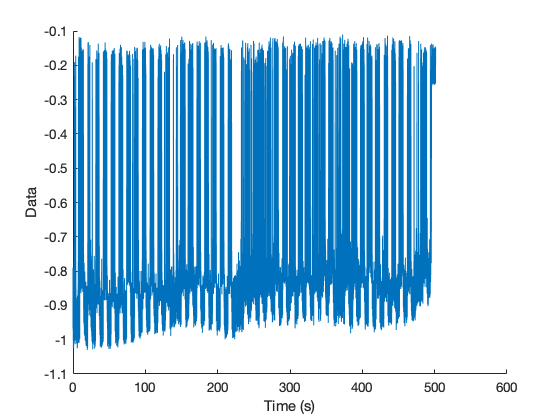

In [69]:
disp(['The channels we have on this daqsystem are the following:']);
disp ( struct2table(getchannels(dev1)) );

sr_d = samplerate(dev1,1,{'digital_in'},1);
sr_a = samplerate(dev1,1,{'analog_in'},1);

disp(['The sample rate of digital channel 1 in epoch 1 is ' num2str(sr_d) '.']);
disp(['The sample rate of analog channel 1 in epoch 1 is ' num2str(sr_a) '.']);

disp(['We will now plot the data for epoch1 for analog_input channel 21.']);

data = readchannels_epochsamples(dev1,{'analog_in'},21,1,0,Inf);
time = readchannels_epochsamples(dev1,{'time'},21,1,0,Inf);

figure;
plot(time,data);
ylabel('Data');
xlabel('Time (s)');
box off;